# LU разложение, блочные и ленточные матрицы

Существует множество типов матриц, удовлетворяющих некоторым дополнительным условиям, для которых многие матричные операции могут быть вычислены быстрее или точнее, чем для матриц произвольного вида. 
В данной лабораторной мы начнем писать библиотеку на Python, которая будет содержать классы, реализующие базовые алгоритмы для работы с основными типами матриц.
Далее приводится исходный код класса `Matrix`, являющегося общим предком для всех матриц, и реализующего логику работы с матрицами общего вида.
Нижеследующий класс `FullMatrix` реализует хранилище для заполненных матриц. 
Изучите эти реализации и выполните следующие задания:

1. +Напишите метод `lu` для класса `Matrix`, выполняющий LU разложение. 
2. +Реализуйте метод `det`, вычисляющий определитель матрицы, опираясь на LU разложение.
3. Реализация `FullMatrix` может содержать своими элементами другие матрицы, т.е. описывать блочную матрицу. Убедитесь, что ваша реализация LU разложения работает с блочными матрицами.
4. Реализуйте LUP разложение с перестановкой строк. Предъявите матрицу, на которой LUP разложение работает, а LU - нет.
5. Реализуйте метод прогонки и реализуйте метод `Matrix.solve` для решения линейных систем уравнений.
6. Реализуйте класс `SymmetricMatrix`, хранящий симметричные матрицы. Убедитесь, что метод `Matrix.lu` корректно работает с этим классом. Модифицируйте этот метод для класса `SymmetricMatrix` так, чтобы он использовал симметричность матрицы и работал в два раза быстрее.
7. Как влияет симметричность матрицы на устойчивость LU разложения?
8. Реализуйте класс `BandMatrix` для хранения ленточных матриц. Убедитесь в работоспособности методов `lu` и `solve`.
9. Воспользуйтесь реализованными классами для решения уравнения Пуассона $\Delta f=g$, использую операцию Лапласа из предыдущей лабораторной.

In [1]:
import numpy as np
from fractions import Fraction
import matplotlib.pyplot as plt

In [2]:
class TextBlock:
    def __init__(self, rows):
        assert isinstance(rows, list)
        self.rows = rows
        self.height = len(self.rows)
        self.width = max(map(len,self.rows))
        
    @classmethod
    def from_str(_cls, data):
        assert isinstance(data, str)
        return TextBlock( data.split('\n') )
        
    def format(self, width=None, height=None):
        if width is None: width = self.width
        if height is None: height = self.height
        return [f"{row:{width}}" for row in self.rows]+[' '*width]*(height-self.height)
    
    @staticmethod
    def merge(blocks):
        return [" ".join(row) for row in zip(*blocks)]
    
class Matrix:
    """Общий предок для всех матриц."""
    @property
    def shape(self):
        raise NotImplementedError
    
    @property
    def dtype(self):
        raise NotImplementedError
    
    @property 
    def width(self):
        return self.shape[1]
    
    @property 
    def height(self):
        return self.shape[0]    
        
    def __repr__(self):
        """Возвращает текстовое представление для матрицы."""
        text = [[TextBlock.from_str(f"{self[r,c]}") for c in range(self.width)] for r in range(self.height)]
        width_el = np.array(list(map(lambda row: list(map(lambda el: el.width, row)), text)))
        height_el = np.array(list(map(lambda row: list(map(lambda el: el.height, row)), text)))
        width_column = np.max(width_el, axis=0)
        width_total = np.sum(width_column)
        height_row = np.max(height_el, axis=1)
        result = []
        for r in range(self.height):
            lines = TextBlock.merge(text[r][c].format(width=width_column[c], height=height_row[r]) for c in range(self.width))
            for l in lines:
                result.append(f"| {l} |")
            if len(lines)>0 and len(lines[0])>0 and lines[0][0]=='|' and r<self.height-1:
                result.append(f'| {" "*(width_total+self.width)}|')
        return "\n".join(result)
    
    def empty_like(self, width=None, height=None):
        raise NotImplementedError
    
    def zero(self, width=None, height=None):
        raise NotImplementedError
    
    def __getitem__(self, key):
        raise NotImplementedError
    
    def __setitem__(self, key, value):
        raise NotImplementedError
        
    def __add__(self, other):
        if isinstance(other, Matrix):
            assert self.width==other.width and self.height==other.height, f"Shapes does not match: {self.shape} != {other.shape}"
            matrix = self.empty_like()
            for r in range(self.height):
                for c in range(self.width):
                    matrix[r,c] = self[r,c] + other[r,c]
            return matrix
        return NotImplemented
    
    def __sub__(self, other):
        if isinstance(other, Matrix):
            assert self.width==other.width and self.height==other.height, f"Shapes does not match: {self.shape} != {other.shape}"
            matrix = self.empty_like()
            for r in range(self.height):
                for c in range(self.width):
                    matrix[r,c] = self[r,c] - other[r,c]
            return matrix
        return NotImplemented

    def __mul__(self, other):
        return self.__matmul__(other)
    def __rmul__(self, other):
        return self.__matmul__(other)
    
    def __matmul__(self, other):
        # add matmul for Matrix and number
        if isinstance(other, float or int or Fraction):
            matrix = self.empty_like()
            for c in range(self.height):
                for r in range(self.width):
                    matrix[r,c] = other*self[r,c]
            return matrix 
        if isinstance(other, Matrix):
            assert self.width==other.height, f"Shapes does not match: {self.shape} != {other.shape}"
            matrix = self.empty_like()
            for r in range(self.height):
                for c in range(other.width):
                    acc = None
                    for k in range(self.width):
                        add = self[r,k]*other[k,c]
                        acc = add if acc is None else acc+add
                    matrix[r,c] = acc
            return matrix
        return NotImplemented
    
    def inverse(self):
        raise NotImplementedError
        
    def invert_element(self, element):
        if isinstance(element, float):
            return 1/element
        if isinstance(element, Fraction):
            return 1/element
        if isinstance(element, Matrix):
            return element.inverse()
        raise TypeError
    
    # student
    # def lu(self):
    #     lu_matrix = self.empty_like()
    #     n = self.shape[0]
    #     for k in range(n):
    #         for j in range(k, n):
    #             s = Fraction(0)
    #             if type(self[0,0]) == FullMatrix:
    #                 s = self.zero(self[0,0].shape[0], self[0,0].shape[0])

    #             for i_ in range(k):
    #                 s += lu_matrix[k,i_]*lu_matrix[i_, j]
                    
    #             lu_matrix[k, j] = self[k, j] - s

    #         for i in range(k + 1, n):
    #             s = Fraction(0)
    #             if type(self[0,0]) == FullMatrix:
    #                 s = self.zero(self[0,0].shape[0], self[0,0].shape[0])

    #             for i_ in range(k):
    #                 s += lu_matrix[i,i_]*lu_matrix[i_, k]

    #             lu_matrix[i, k] = (self[i, k] - s) / lu_matrix[k, k]
                
    #     return lu_matrix
    
    # question 1
    def lu(self):
        c = self.copy()
        for i in range(self.shape[0]):
            for j in range(i+1, self.shape[0]):
                        c[j, i] /= c[i,i]
                        for k in range(i+1, self.shape[0]):
                            c[j,k]-=c[j,i]*c[i,k]
        return c


    # student
    def get_l(self):
        l = self.lu()
        
        for i in range(l.shape[0]):
                if type(l[i,i]) == FullMatrix:
                    l[i,i] = FullMatrix.zero(*l[i,i].shape, Fraction(0))
                    for li in range(min(l[i,i].shape)):
                        (l[i,i])[li,li] = Fraction(1)
                    for j in range(i+1, l.shape[1]):
                        l[i,j] = FullMatrix.zero(*l[i,j].shape, Fraction(0))
                else:
                    l[i, i] = 1
                    for j in range(i+1, l.shape[1]):
                        l[i,j] = 0
        return l
    
    # student
    def get_u(self):
        u = self.lu()
        for i in range(u.shape[0]):
                for j in range(i):
                    if type(u[i,j]) == FullMatrix:
                        u[i,j] = FullMatrix.zero(*u[i,j].shape, Fraction(0))
                    else:
                        u[i,j] = 0

        return u
    
    # student
    def det(self):
        u = self.get_u()

        det = u[0,0]
        for i in range(1, self.shape[0]):
                det*=u[i,i]
        return det

    # https://courses.physics.illinois.edu/cs357/sp2020/notes/ref-9-linsys.html
    # student
    def solve_lup(self, b):
        x = FullMatrix.empty_like(b) # l*u*x = p*b
        y = FullMatrix.empty_like(b) # l*y = p*b
        lu, p = self.lup()
        pb = p*b
        for i in range(b.shape[0]):
            for j in range(b.shape[1]):
                y[i,j] = pb[i,j]
                for k in range(i):
                    if i<=k:
                        print(i,k, 'catch')
                    y[i,j]-=lu[i,k]*y[k,j]         
        for i in range(b.shape[0]-1, -1, -1):
            for j in range(b.shape[1]-1, -1, -1):
                x[i,j] = y[i,j]/lu[i,i]
                for k in range(y.shape[0]-1, i, -1):
                    x[i,j] -= lu[i,k]*x[k,j]/lu[i,i]
        return x
    
    def copy(self):
        c = self.empty_like(self.shape[0], self.shape[1])
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                c[i,j] = self[i,j]
        return c

    def swaprows(self, i_r, j_r):
        c = self.copy()
        for i in range(self.shape[1]):
            acc = c[i_r, i]
            c[i_r, i] = c[j_r, i]
            c[j_r, i] = acc
        return c

    # Вроде работает 
    def lup(self):
        c = self.copy()
        p = FullMatrix.zero(self.shape[0], self.shape[1], Fraction(0))
        for i in range(self.shape[0]):
            p[i,i] = Fraction(1)
        for i in range(self.shape[0]):
            pVal = Fraction(0)
            pivot = -1
            for row in range(i, self.shape[0]):
                if abs(c[row, i]) > pVal:
                    pVal = abs(c[row, i])
                    pivot = row
            if pVal !=Fraction(0):
                p = p.swaprows(pivot, i)
                c = c.swaprows(pivot, i)
                for j in range(i+1, self.shape[0]):
                    c[j, i] /= c[i,i]
                    for k in range(i+1, self.shape[0]):
                        c[j,k]-=c[j,i]*c[i,k]
        return c, p
    def get_l_p(self):
        l = self.lup()[0]
        for i in range(self.shape[0]):
            l[i,i] = Fraction(1)
            for j in range(i+1, self.shape[1]):
                l[i,j] = Fraction(0)
        return l
    def get_u_p(self):
        u = self.lup()[0]
        for i in range(self.shape[0]):
            for j in range(i):
                u[i,j] = Fraction(0)
        return u
    
    def T(self):
        dat = self.data
        return FullMatrix(dat.T)
        
    
    # поменять под LUP 
    def __truediv__(self ,other):
        e = other.zero(*other.shape, Fraction(0))
        for i in range(other.shape[0]):
            e[i,i] = Fraction(1)
        return self*other.solve_lup(e)
    def __rtruediv__(self, other):
        e = self.zero(*self.shape, Fraction(0))
        for i in range(self.shape[0]):
            e[i,i] = Fraction(1)
        return other*self.solve_lup(e)
        

        

class FullMatrix(Matrix):
    """
    Заполненная матрица с элементами произвольного типа.
    """
    def __init__(self, data):
        """
        Создает объект, хранящий матрицу в виде np.ndarray `data`.
        """
        assert isinstance(data, np.ndarray)
        self.data = data

    def empty_like(self, width=None, height=None):
        dtype = self.data.dtype
        if width is None:
            width = self.data.shape[1]
        if height is None:
            height = self.data.shape[0]       
        data = np.empty((height,width), dtype=dtype)
        return FullMatrix(data)

    @classmethod
    def zero(_cls, height, width, default=0):
        """
        Создает матрицу размера `width` x `height` со значениями по умолчанию `default`.
        """
        data = np.empty((height, width), dtype=type(default))
        data[:] = default
        return FullMatrix(data)
                    
    @property
    def shape(self):
        return self.data.shape
    
    @property
    def dtype(self):
        return self.data.dtype
        
    def __getitem__(self, key):
        row, column = key
        return self.data[row, column]
    
    def __setitem__(self, key, value):
        row, column = key
        self.data[row, column] = value
        

In [3]:
class SymmetricMatrix(Matrix):
    def __init__(self, data):
        """
        Создает объект, хранящий матрицу в виде np.ndarray `data`.
        """
        assert isinstance(data, np.ndarray)
        self.data = data

    def empty_like(self, width=None, hight=None):
        height = width
        dtype = self.data.dtype
        if width is None:
            width = self.data.shape[1]
        if height is None:
            height = self.data.shape[0]       
        data = np.empty((height,width), dtype=dtype)
        return SymmetricMatrix(data)

    @classmethod
    def zero(_cls, height, width, default=0):
        """
        Создает матрицу размера `width` x `height` со значениями по умолчанию `default`.
        """
        data = np.empty((height, width), dtype=type(default))
        data[:] = default
        return SymmetricMatrix(data)
                    
    @property
    def shape(self):
        return self.data.shape
    
    @property
    def dtype(self):
        return self.data.dtype
        
    def __getitem__(self, key):
        return self.data[max(key), min(key)]
    
    def __setitem__(self, key, value):
        self.data[max(key), min(key)] = value

In [4]:
class BandMatrix(Matrix):
    def __init__(self, diagonal, lower_diagonals=[], upper_diagonals=[]):
        """
        Создает ленточную матрицу.
        `diagonal` - список элементов главной диагонали,
        `lower_diagonals` - список диагоналей ниже главной, начиная с ближайшей к главной.
        `upper_diagonals` - список диагоналей выше главной, начиная с ближайшей к главной.
        """
        self._diagonal = diagonal
        self._lower_diagonals = lower_diagonals
        self._upper_diagonals = upper_diagonals
    @property
    def n(self): return len(self._diagonal) # Размер матрицы (матрица всегда квадратная).
    @property
    def p(self): return len(self._lower_diagonals) # Число диагоналей ниже главной.
    @property
    def q(self): return len(self._upper_diagonals) # Число диагоналей выше главной.
    @property
    def shape(self): # Переопределяем вычисление размера 
        return (self.n,)*2
    def __getitem__(self, key): # Извлечение элемента матрицы (или подматрицы).
        (i,j) = key # Распаковываем индексы матрицы.
        d = j-i # Номер диагонали, верхние с плюсом.
        if d>self.q or d<-self.p: return 0 # Элемент вне ленты.
        n = (j+i-abs(d))//2 # Номер элемента на диагонали (считая от верхнего/левого элемента).
        return (self._diagonal[n] if d==0 else 
                self._upper_diagonals[d-1][n] if d>0 else 
                self._lower_diagonals[-d-1][n])
    def __setitem__(self, key, value):
        (i,j) = key
        d = j-i # Номер диагонали, верхние с плюсом.
        n = (j+i-abs(d))//2
        if d>self.q:
            for new_q in range(self.q, d):
                self._upper_diagonals.append([0]*(self.n-new_q))
            self._upper_diagonals[-1][n] = value
        elif d<-self.p:
            for new_p in range(-self.p-1, d-1, -1):
                self._lower_diagonals.append([0]*(self.n+new_p))
            self._lower_diagonals[-1][n] = value
        elif d == 0:
            self._diagonal[n] = value
        elif d > 0:
            self._upper_diagonals[d-1][n] = value
        elif d < 0:
            self._lower_diagonals[-d-1][n] = value

    def to_dense(self): # Преобразует матрицу к плотной матрице в виде массива numpy.
        result = np.zeros(self.shape)
        for i in range(self.shape[0]):
            for j in range(self.shape[1]): # TODO Можно перебирать меньше элементов.
                result[i,j] = self[i,j]
        return result
    

    @staticmethod
    def multiply(a, b):
        if a.n != b.n:
            raise ValueError("Matrices cannot be multiplied!")

        n = a.n
        m = b.n

        lower_bandwidth = max(a.p, b.p)
        upper_bandwidth = max(a.q, b.q)
        allMax = max(lower_bandwidth, upper_bandwidth)*2

        c = BandMatrix([0]*(n), [], [])

        for i in range(n):
            for j in range(max(0, i-allMax), min(n, i+allMax)):
                sum = 0
                for k in range(max(0, i - lower_bandwidth), min(n, i + upper_bandwidth + 1)):
                    sum += a[i, k] * b[k, j]
                c[i, j] = sum

        return c


    def __matmul__(self, other):
        if a.n != b.n:
            raise ValueError("Matrices cannot be multiplied!")

        n = self.n
        m = other.n

        lower_bandwidth = max(self.p, other.p)
        upper_bandwidth = max(self.q, other.q)
        allMax = max(lower_bandwidth, upper_bandwidth)*2

        c = BandMatrix([0]*(n), [], [])

        for i in range(n):
            for j in range(max(0, i-allMax), min(n, i+allMax)):
                sum = 0
                for k in range(max(0, i - lower_bandwidth), min(n, i + upper_bandwidth + 1)):
                    sum += self[i, k] * other[k, j]
                c[i, j] = sum

        return c

            

    
    
a = BandMatrix(diagonal=[1,2,3,4], lower_diagonals=[[5,6,7],[8,9]], upper_diagonals=[[10,11,12]])
b = BandMatrix(diagonal=[1,1,1,1])

In [5]:
n = 11

A = BandMatrix(diagonal=list(range(1, n)), lower_diagonals=[list(range(1, n-1)), list(range(1, n-2))],  upper_diagonals=[list(range(1, n-1))])
B = BandMatrix(diagonal=list(range(1+2, n+2)), lower_diagonals=[list(range(1+2, n-1+2)), list(range(1+2, n-2+2))],  upper_diagonals=[list(range(1+2, n-1+2))])

In [6]:
A@B

| 6  7  4  0  0   0   0   0   0   0   |
| 15 19 18 10 0   0   0   0   0   0   |
| 18 35 38 33 18  0   0   0   0   0   |
| 15 36 63 63 52  28  0   0   0   0   |
| 9  28 60 99 94  75  40  0   0   0   |
| 0  16 45 90 143 131 102 54  0   0   |
| 0  0  25 66 126 195 174 133 70  0   |
| 0  0  0  36 91  168 255 223 168 88  |
| 0  0  0  0  49  120 216 323 278 207 |
| 0  0  0  0  0   64  153 270 289 219 |

In [7]:
A@A

| 2 3  2  0  0   0   0   0   0   0   |
| 5 9  10 6  0   0   0   0   0   0   |
| 6 17 22 21 12  0   0   0   0   0   |
| 5 18 37 41 36  20  0   0   0   0   |
| 3 14 36 65 66  55  30  0   0   0   |
| 0 8  27 60 101 97  78  42  0   0   |
| 0 0  15 44 90  145 134 105 56  0   |
| 0 0  0  24 65  126 197 177 136 72  |
| 0 0  0  0  35  90  168 257 226 171 |
| 0 0  0  0  0   48  119 216 235 181 |

In [8]:
s = SymmetricMatrix.zero(3, 3, 1)

In [9]:
s.lu()

<ipython-input-2-99f3d0880239>:159: RuntimeWarning: divide by zero encountered in long_scalars
  c[j, i] /= c[i,i]


OverflowError: cannot convert float infinity to integer

In [ ]:
delta(3).lu()

| -2 1  1  |
| 0  -2 1  |
| 0  0  -2 |

In [ ]:
s.data = delta(3).data

In [ ]:
s

| -2 1  0  1  |
| 1  -2 1  0  |
| 0  1  -2 1  |
| 1  0  1  -2 |

In [ ]:
s

In [ ]:
s[0,1] = 1

s[1,0] = 2

In [ ]:
s

## Вопрос 1

Проверим LU-разложение на операторе Лапласа в 1D:

In [ ]:
def delta(n=4):
    d = FullMatrix.zero(n,n,0)

    d[0, 0], d[0, 1] = -2,  1
    d[n-1, n-1], d[n-1, n-2] = -2, 1

    for i in range(1, d.shape[0]-1):
        d[i, i] = -2
        d[i, i+1 % n] = 1
        d[i, i-1 % n] = 1
    d[0, -1] = 1
    d[-1, 0] = 1
    return d

In [ ]:
D = delta(4)

In [ ]:
n = 2**6

a, b = 0, 2*np.pi

datag = np.sin(np.linspace(a, b, n))

g = FullMatrix.zero(n, 1)

g.data = datag.reshape(n, 1)


D = delta(n)

In [ ]:
nD = np.array(D.data, dtype=int)

In [ ]:
npSol = np.linalg.solve(nD, np.array(g.data, dtype=float)).ravel()*(b-a)**2/n**2

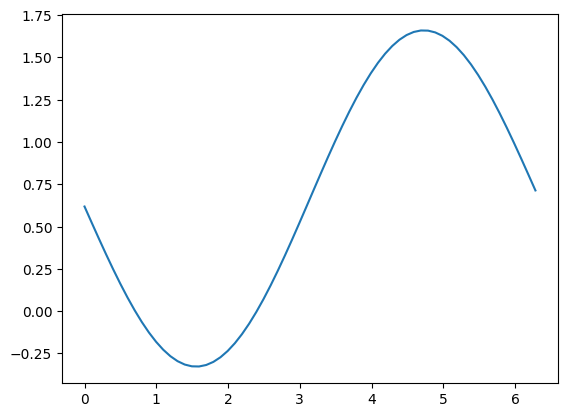

In [ ]:
plt.plot(np.linspace(a, b, n), npSol)

In [ ]:
D.solve_lup(g)

| -0.0976273182954818    |
| -0.1952546365909637    |
| -0.2909414265861107    |
| -0.38373670997282383   |
| -0.4727182455347434    |
| -0.557001694794792     |
| -0.6357494109682658    |
| -0.7081787638729093    |
| -0.7735699180592792    |
| -0.83127298685884      |
| -0.8807144912496503    |
| -0.921403059348529     |
| -0.9529343098855891    |
| -0.974994871126974     |
| -0.987365495303936     |
| -0.9899232375956639    |
| -0.9826426780101478    |
| -0.9655961740194794    |
| -0.9389531414387868    |
| -0.9029783706957502    |
| -0.8580293952243685    |
| -0.804552938137064     |
| -0.7430804724896893    |
| -0.6742229392635222    |
| -0.5986646755593104    |
| -0.5171566133477012    |
| -0.4305088163699251    |
| -0.33958242936035204   |
| -0.24528111960314583   |
| -0.14854209588062317   |
| -0.050326794070952904  |
| 0.04838867803426847    |
| 0.14662324172923397    |
| 0.24340059779777068    |
| 0.3377589294193669     |
| 0.42876046114844024    |
| 0.5155007789712118     |
|

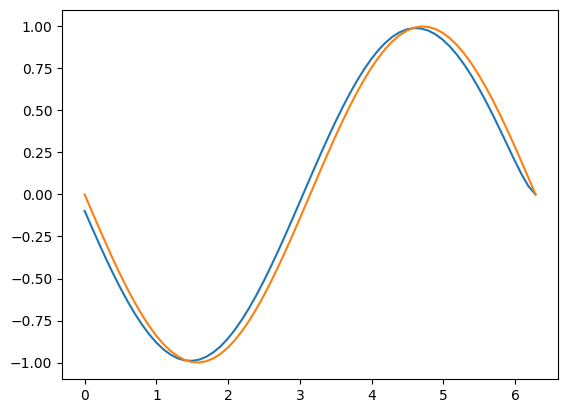

In [ ]:
plt.plot(np.linspace(a, b, n), D.solve_lup(g).data.T[0])
plt.plot(np.linspace(a, b, n), -np.sin(np.linspace(a, b, n)))

In [ ]:
b = FullMatrix.zero(4, 1, Fraction(2, 5))

In [ ]:
d = delta()

In [ ]:
print(f"d:\n{d}\nL, U:\n{d.get_l()}<-L\n\n{d.get_u()}<-U\nL*U:\n{d.get_l()*d.get_u()}")

d:
| -2 1  0  1  |
| 1  -2 1  0  |
| 0  1  -2 1  |
| 1  0  1  -2 |
L, U:
| 1 0 0 0 |
| 0 1 0 0 |
| 0 0 1 0 |
| 0 0 0 1 |<-L

| -2 1  0  1  |
| 0  -2 1  0  |
| 0  0  -2 1  |
| 0  0  0  -2 |<-U
L*U:
| -2 1  0  1  |
| 0  -2 1  0  |
| 0  0  -2 1  |
| 0  0  0  -2 |


Действительно работает, но не для всех матриц (хотя оператор Лапаласа точно работает)

## Вопрос 2

Сравним значение с numpy:

In [ ]:
d

| -2 1  0  1  |
| 1  -2 1  0  |
| 0  1  -2 1  |
| 1  0  1  -2 |

In [ ]:
dnp = (np.array([[2,1,0,0],
          [1,2,1,0],
          [0,1,2,1],
          [0,0,1,2]]))

In [ ]:
print("det for numpy matrix:\t\t %.0f"%np.linalg.det(dnp))
print("det for FullMatrix matrix:\t %.0f"%d.det())


det for numpy matrix:		 5
det for FullMatrix matrix:	 16


Работает.

## Вопрос 3

In [11]:
ts = FullMatrix.zero(2, 2, Fraction(10))
ts[0,1] = Fraction(1)
ts[1,0] = Fraction(1)


In [12]:
e2 = FullMatrix.zero(*ts.shape, Fraction(0))

for i in range(e2.shape[0]):
    e2[i,i] = Fraction(1)


In [13]:
blkM = FullMatrix.zero(3, 3, ts)
for i in range(blkM.shape[0]):
    for j in range(blkM.shape[1]):
        if i!=j:
            blkM[i,j] = e2

In [14]:
blkM

| | 10 1  | | 1 0 |   | 1 0 |   |
| | 1  10 | | 0 1 |   | 0 1 |   |
|                               |
| | 1 0 |   | 10 1  | | 1 0 |   |
| | 0 1 |   | 1  10 | | 0 1 |   |
|                               |
| | 1 0 |   | 1 0 |   | 10 1  | |
| | 0 1 |   | 0 1 |   | 1  10 | |

In [15]:
blkM.lu()

TypeError: unsupported operand type(s) for |: 'type' and 'type'

In [ ]:
blkM.get_l()*blkM.get_u()

| | 10 1  | | 1 0 |   | 1 0 |   |
| | 1  10 | | 0 1 |   | 0 1 |   |
|                               |
| | 1 0 |   | 10 1  | | 1 0 |   |
| | 0 1 |   | 1  10 | | 0 1 |   |
|                               |
| | 1 0 |   | 1 0 |   | 10 1  | |
| | 0 1 |   | 0 1 |   | 1  10 | |

## Вопрос 4

Приведем пример матрицы, для которой не работает LU, но работает LUP

In [ ]:
m = FullMatrix.zero(4,4, Fraction(0))

for i in range(m.shape[0]):
    for j in range(m.shape[1]):
        m[i,j] = Fraction(1+i, 1+j)
print(m)

| 1 1/2 1/3 1/4 |
| 2 1   2/3 1/2 |
| 3 3/2 1   3/4 |
| 4 2   4/3 1   |


In [ ]:
try:
    m.lu()
except ZeroDivisionError:
    print("деление на ноль")

деление на ноль


In [ ]:
*m.lup(), m.get_l_p()*m.get_u_p(), m.lup()[1]*m

(| 4   2 4/3 1 |
 | 1/2 0 0   0 |
 | 3/4 0 0   0 |
 | 1/4 0 0   0 |,
 | 0 0 0 1 |
 | 0 1 0 0 |
 | 0 0 1 0 |
 | 1 0 0 0 |,
 | 4 2   4/3 1   |
 | 2 1   2/3 1/2 |
 | 3 3/2 1   3/4 |
 | 1 1/2 1/3 1/4 |,
 | 4 2   4/3 1   |
 | 2 1   2/3 1/2 |
 | 3 3/2 1   3/4 |
 | 1 1/2 1/3 1/4 |)

## Вопрос 5

In [ ]:
b = FullMatrix.zero(4, 1, Fraction(2, 7))

In [ ]:
d*d.solve_lup(b)

| 0 1  0  1  |
| 0 -2 1  0  |
| 0 0  -2 1  |
| 0 0  0  -2 |